# Automated testing

In [1]:
import classifier

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import copy
from sklearn.metrics import confusion_matrix

2024-05-01 09:38:27.682391: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-01 09:38:28.964898: I tensorflow/compiler/xla/stream_executor/rocm/rocm_gpu_executor.cc:838] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-01 09:38:28.982474: I tensorflow/compiler/xla/stream_executor/rocm/rocm_gpu_executor.cc:838] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-01 09:38:28.982534: I tensorflow/compiler/xla/stream_executor/rocm/rocm_gpu_executor.cc:838] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA

1 Physical GPUs, 1 Logical GPUs


In [2]:
INPUT_WIDTH = 3
# start with a sequence length of 120
SEQ_LEN=180

# do 5 test runs
RUNS=1

## Load data

In [3]:
players_inputs = classifier.players_inputs('dataset/velocities')
num_players = len(players_inputs.keys())

## Testing Functions

In [4]:
def get_accs(hs, ys):
    
    ranks = []
    for i in range(hs.shape[0]):
        rankings = np.argsort(hs[i])
        rank = (num_players-1) - np.where((rankings == np.argmax(ys[i])))[0][0]
        ranks.append(rank)
    
    # top n accuracy
    topn_occurences = []
    running = 0
    for i in range(num_players):
        topn_occurences.append(ranks.count(i) + running)
        running += ranks.count(i)

    topn_acc = [t / topn_occurences[-1] for t in topn_occurences]

    return topn_acc

def get_confusion(hs, ys):
    # confusion matrix
    c_matrix = [[0 for i in range(num_players)] for j in range(num_players)]
    for i in range(len(hs)):
        actual = np.argmax(ys[i])
        predicted = np.argmax(hs[i])
        # y axis is predicted value, x axis is actual value
        c_matrix[predicted][actual] += 1

    return c_matrix

def test_model(model, test_x, test_y):    

    # test
    test_h = model.predict(test_x)

    # get hard predictions
    predicted = [np.argmax(test_h[i]) for i in range(len(test_h))]
    actual = [np.argmax(test_y[i]) for i in range(len(test_y))]

    # organize results
    topn_acc = get_accs(test_h, test_y)
    c_matrix = confusion_matrix(predicted, actual, normalize='true')

    return topn_acc, c_matrix

## Test

In [5]:
def test_run(model):
    (train_x, train_y), (valid_x, valid_y), (test_x, test_y) = classifier.prepare_data(players_inputs, seq_len=SEQ_LEN)

    print(f'{len(train_x)=}, {len(valid_x)=}, {len(test_x)=}')

    history = model.fit(
        train_x, train_y, epochs=80, verbose=0, batch_size=64, validation_data=(valid_x, valid_y)
    )

    # run the tests
    topn_acc, c_matrix = test_model(model, test_x, test_y)

    return history, topn_acc, c_matrix

In [6]:
model = classifier.createClassifier(width=3, seq_len=SEQ_LEN)
model.summary()

model.save_weights('models/untrained')

2024-05-01 09:38:30.337478: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-05-01 09:38:30.339288: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-05-01 09:38:30.393037: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-05-01 09:38:30.396471: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-05-01 09:38:30.399687: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-05-01 09:38:30.402726: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-05-01 09:38:30.405528: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-05-01 09:38:30.408601: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-05-01 09:38:30.409261: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-05-01 09:38:30

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 180, 3)]             0         []                            
                                                                                                  
 conv1d (Conv1D)             (None, 87, 32)               704       ['input_1[0][0]']             
                                                                                                  
 conv1d_1 (Conv1D)           (None, 178, 32)              320       ['input_1[0][0]']             
                                                                                                  
 concatenate (Concatenate)   (None, 265, 32)              0         ['conv1d[0][0]',              
                                                                     'conv1d_1[0][0]']        

2024-05-01 09:38:30.777514: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-05-01 09:38:30.778420: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-05-01 09:38:30.779686: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-05-01 09:38:30.780515: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-05-01 09:38:30.784007: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-05-01 09:38:30.785032: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-05-01 09:38:30.785972: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-05-01 09:38:30.791761: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-05-01 09:38:30.792285: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-05-01 09:38:30

In [7]:
histories = []
topns = []
c_matrices = []

for i in range(RUNS):
    # reset the model
    model.load_weights('models/untrained')

    # do a test run
    h, t, c = test_run(model)
    
    histories.append(h)
    topns.append(t)
    c_matrices.append(c)

2024-05-01 09:38:30.858121: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-05-01 09:38:30.859925: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.


len(train_x)=12111, len(valid_x)=4037, len(test_x)=4037


2024-05-01 09:38:31.584668: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-05-01 09:38:31.586668: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-05-01 09:38:31.591139: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-05-01 09:38:31.591865: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-05-01 09:38:31.599059: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-05-01 09:38:31.599983: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-05-01 09:38:31.608396: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-05-01 09:38:31.609861: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-05-01 09:38:31.615210: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-05-01 09:38:31

  9/127 [=>............................] - ETA: 1s

2024-05-01 09:46:45.635823: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-05-01 09:46:45.676739: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-05-01 09:46:45.712138: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.


127/127 [==============================] - 2s 13ms/step


2024-05-01 09:46:47.332077: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-05-01 09:46:47.333685: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-05-01 09:46:47.386805: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-05-01 09:46:47.403125: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-05-01 09:46:47.404781: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-05-01 09:46:47.407858: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-05-01 09:46:47.414291: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.


# deal with the results

In [8]:
# t_hists = list(zip(*histories[::-1]))
t_accs = list(zip(*topns[::-1]))

### top n accuracies

In [9]:
avg_accs = []
for n in t_accs:
    avg_accs.append(sum(n) / len(n))

print(f'{t_accs}\n{avg_accs}')

[(0.8625216745107753,), (0.9469903393609116,), (0.9734951696804558,), (0.9846420609363389,), (0.9918256130790191,), (0.9955412434976467,), (0.9982660391379737,), (0.9990091652216992,), (0.9990091652216992,), (0.9992568739162745,), (0.9997522913054249,), (0.9997522913054249,), (0.9997522913054249,), (1.0,), (1.0,), (1.0,)]
[0.8625216745107753, 0.9469903393609116, 0.9734951696804558, 0.9846420609363389, 0.9918256130790191, 0.9955412434976467, 0.9982660391379737, 0.9990091652216992, 0.9990091652216992, 0.9992568739162745, 0.9997522913054249, 0.9997522913054249, 0.9997522913054249, 1.0, 1.0, 1.0]


### confusion matrix

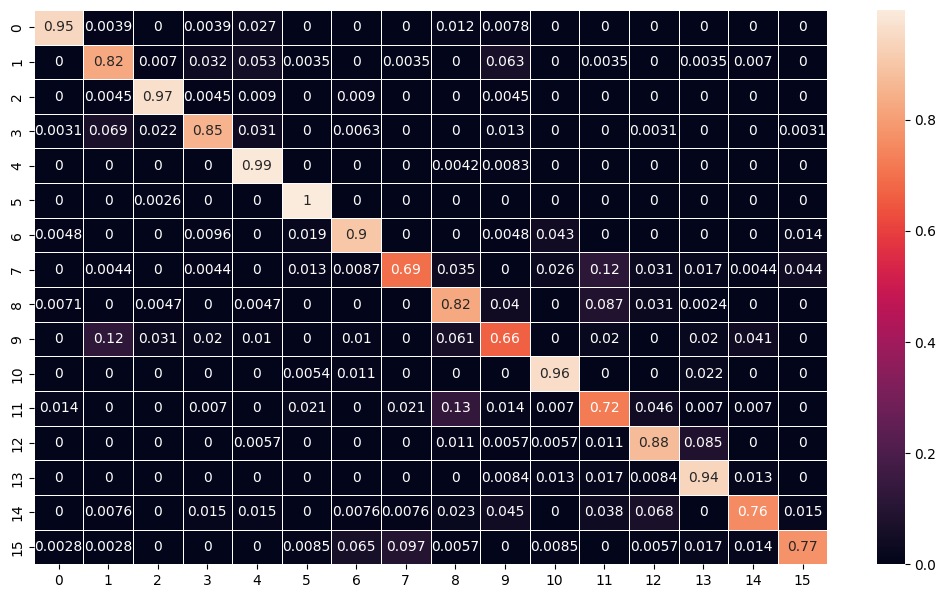

In [15]:

px = 1/plt.rcParams['figure.dpi']  # pixels per inch
plt.subplots(figsize=(1280*px, 720*px))

ax = sns.heatmap(c_matrices[0], linewidth=.6, annot=True)
plt.savefig(f'results/180_matrix')
plt.show()

In [11]:
classifier.mapping()

{'2saint': 0,
 'aklo': 1,
 'amsa': 2,
 'axe': 3,
 'cody': 4,
 'hbox': 5,
 'kodorin': 6,
 'logan': 7,
 'mang0': 8,
 'moky': 9,
 'n0ne': 10,
 'plup': 11,
 'sfat': 12,
 'wizzrobe': 13,
 'yingling': 14,
 'zain': 15}

## learning curve

In [12]:
# average the histories

t_accs = np.array([[x for x in h.history['accuracy']] for h in histories])
mean_accs = np.mean(t_accs, axis=0)
v_accs = np.array([[x for x in h.history['val_accuracy']] for h in histories])
mean_val_accs = np.mean(v_accs, axis=0)
mean_val_accs.shape

avg_history = {'accuracy': histories[0].history['accuracy'], 'val_accuracy': histories[0].history['val_accuracy']}

In [13]:
len(histories)

1

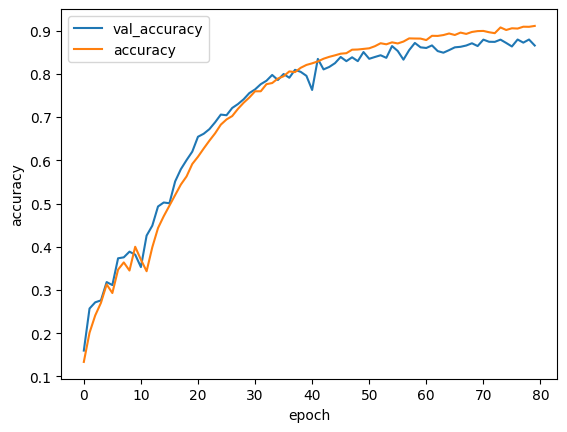

In [14]:
plt.plot('val_accuracy', data=avg_history)
plt.plot('accuracy', data=avg_history)
plt.ylabel('accuracy')
plt.xlabel('epoch')

plt.legend()

# plt.savefig(f'results/GRU_curve')
plt.show()